#Başlayalım

cats_and_dogs zip dosyası ile verilerimizi çekelim

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-08-15 15:20:42--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   250MB/s    in 0.3s    

2020-08-15 15:20:42 (250 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



dosya işlemlerinin yapalım

In [ ]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

klavuz/direction işlemlerini yapalım

In [ ]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')

train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')

validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Modelimizi kuralım

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Modelimizi derleyelim/compile edelim

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['accuracy'])

## Bu noktadan sonra eğitimi **2 farklı** şekilde yapacağız.

### 1. Verimizi çeşitlendirme yapmadan/**Without Augmentation**
### 2. Verimizi çeşitlendirme yaparak/**With Augmentation**

İlk olarak çeşitlendirm yapmadanı yapalım ki bunu daha önce de görmüştük.

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=1)

Epoch 1/100
100/100 [==============================] - 9s 90ms/step - loss: 0.6917 - accuracy: 0.5335 - val_loss: 0.6694 - val_accuracy: 0.5670
Epoch 2/100
100/100 [==============================] - 9s 88ms/step - loss: 0.6674 - accuracy: 0.5955 - val_loss: 0.6497 - val_accuracy: 0.5700
Epoch 3/100
100/100 [==============================] - 9s 88ms/step - loss: 0.6144 - accuracy: 0.6570 - val_loss: 0.6021 - val_accuracy: 0.6770
Epoch 4/100
100/100 [==============================] - 9s 88ms/step - loss: 0.5671 - accuracy: 0.7070 - val_loss: 0.6085 - val_accuracy: 0.6540
Epoch 5/100
100/100 [==============================] - 9s 87ms/step - loss: 0.5381 - accuracy: 0.7255 - val_loss: 0.5758 - val_accuracy: 0.6900
Epoch 6/100
100/100 [==============================] - 9s 90ms/step - loss: 0.5119 - accuracy: 0.7465 - val_loss: 0.5820 - val_accuracy: 0.6810
Epoch 7/100
100/100 [==============================] - 9s 90ms/step - loss: 0.4904 - accuracy: 0.7505 - val_loss: 0.6737 - val_accuracy:

Bu yöntemin doğruluğuna bakalım

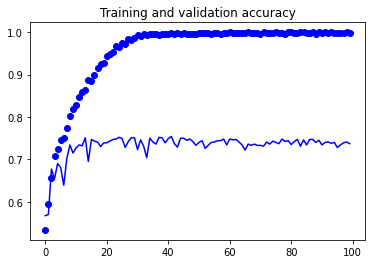

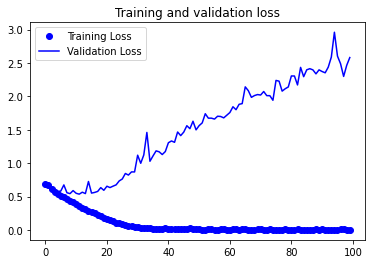

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Güzel şimdi verimizi çeşitlendirme yöntemi ile  yapalım/ **With data Augmentation**

#### Bilinmesi gereken bazı husular

1. **rotation_range=x** resim 0 ile x derece arasında rastgele bir değer seçilerek döndürülür.(x=40 gibi)
2. **width_shift_range=x** ve **height_shift_range=x** resmi enine veya boyuna belirtilen oranda kaydırır (x=0.2 gibi)
3. **shear_range=x** derece cinsinden saat yönününün tersine resmi döndürür.(x=0.2 gibi)
4. **zoom_range=x** yine belirtilen oran ile 0 arasında rastgele bir oran ile resmi yakınlaştırır. (x=0.2 gibi)
5. **horizontal_flip=True** dikey eksende yansımasını alır.
6. **fill_mode="nearest** yukarda yyapılan işlemler veya buna benzer başka işlemlerden ötürü pixel kaybolursa ,kaybolan pixelleri doldurma komutu."nearest" ölü pixelin en yakınındaki pixel ile doldurulur.

In [ ]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

Üstteki kod kutusu ile veri çeşitlendirmemizi yaptık.

Diğer işlemler aynı

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2)

Epoch 1/100
100/100 - 17s - loss: 1.2861 - accuracy: 0.6750 - val_loss: 0.5503 - val_accuracy: 0.7330
Epoch 2/100
100/100 - 17s - loss: 0.5896 - accuracy: 0.6785 - val_loss: 0.5154 - val_accuracy: 0.7490
Epoch 3/100
100/100 - 17s - loss: 0.5674 - accuracy: 0.7090 - val_loss: 0.5099 - val_accuracy: 0.7560
Epoch 4/100
100/100 - 18s - loss: 0.5702 - accuracy: 0.7225 - val_loss: 0.5166 - val_accuracy: 0.7460
Epoch 5/100
100/100 - 17s - loss: 0.5577 - accuracy: 0.7125 - val_loss: 0.5613 - val_accuracy: 0.7370
Epoch 6/100
100/100 - 18s - loss: 0.5502 - accuracy: 0.7240 - val_loss: 0.5067 - val_accuracy: 0.7600
Epoch 7/100
100/100 - 17s - loss: 0.5418 - accuracy: 0.7330 - val_loss: 0.4881 - val_accuracy: 0.7820
Epoch 8/100
100/100 - 17s - loss: 0.5384 - accuracy: 0.7180 - val_loss: 0.5119 - val_accuracy: 0.7580
Epoch 9/100
100/100 - 18s - loss: 0.5258 - accuracy: 0.7320 - val_loss: 0.5008 - val_accuracy: 0.7640
Epoch 10/100
100/100 - 18s - loss: 0.5352 - accuracy: 0.7280 - val_loss: 0.5290 - 

Yeni işlemin doğruluğuna bakalım

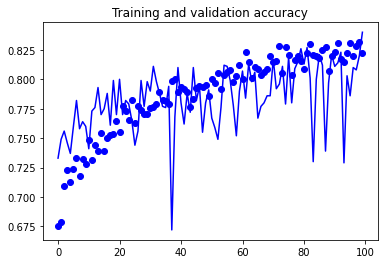

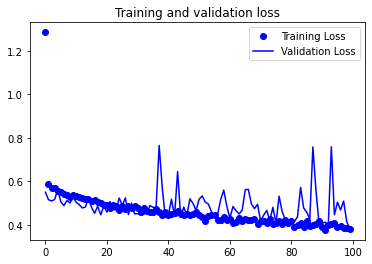

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Göründüğü gibi çeşitlendirme olumlu yönde sonuç verdi